In [1]:
import math

from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.stats import weibull_min

# Data loading

In [2]:
avg_income = pd.read_csv('../data/average_monthly_household_income.csv')
avg_income.shape

(10, 4)

In [3]:
avg_income.head()

,decile,2019,change in 2020,2020
0,1-10,2045,-6.10%,1920.26
1,11-20,4121,-3.20%,3989.13
2,21-30,5893,-2.20%,5763.35
3,31-40,7788,-2.00%,7632.24
4,41-50,9829,-1.50%,9681.57


# L1 loss as goodness-of-fit measure

In [4]:
def objective(c, scale):
    return -l1_loss(avg_income['2020'], c, scale)
    
    
def l1_loss(data, c, scale):
    data = np.asarray(data)
    
    # data must be a 1x10 vector, with the i-th element being 
    # the average income of the i-th decile of the population
    assert data.size == 10
    
    # scale down the data and parameter for robust numerical behaviour
    factor = 10 ** math.floor(math.log10(data.max()))
    
    decile_avgs = weibull_decile_averages(c, scale/factor) * factor

    # calculate and return L1 loss
    return np.linalg.norm(data-decile_avgs, 1)


def weibull_decile_averages(c, scale):
    # find the deciles of the Weibull
    deciles = weibull_min.ppf(np.linspace(0, 1, 11), c, scale=scale)
    
    # calculate and return the average for each decile using numerical integration
    return np.array([
        integrate.quad(
            lambda x: x * weibull_min.pdf(x, c, scale=scale), 
            deciles[i], 
            deciles[i+1]
        )[0] / .1
        for i in range(deciles.size-1)
    ])

# Parameter optimization

In [5]:
pbounds = {'c': (1.3, 1.6), 'scale': (8000, 15000)}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(init_points=50, n_iter=100)

|   iter    |  target   |     c     |   scale   |
-------------------------------------------------
|  1        | -3.765e+0 |  1.425    |  1.304e+0 |
|  2        | -2.785e+0 |  1.3      |  1.012e+0 |
|  3        | -4.193e+0 |  1.344    |  8.646e+0 |
|  4        | -2.581e+0 |  1.356    |  1.042e+0 |
|  5        | -1.421e+0 |  1.419    |  1.177e+0 |
|  6        | -5.223e+0 |  1.426    |  1.28e+04 |
|  7        | -9.768e+0 |  1.361    |  1.415e+0 |
|  8        | -7.488e+0 |  1.308    |  1.269e+0 |
|  9        | -1.302e+0 |  1.425    |  1.191e+0 |
|  10       | -3.511e+0 |  1.342    |  9.387e+0 |
|  11       | -1.172e+0 |  1.54     |  1.478e+0 |
|  12       | -4.948e+0 |  1.394    |  1.285e+0 |
|  13       | -7.306e+0 |  1.563    |  1.426e+0 |
|  14       | -4.516e+0 |  1.326    |  8.273e+0 |
|  15       | -1.023e+0 |  1.351    |  1.415e+0 |
|  16       | -2.061e+0 |  1.33     |  1.095e+0 |
|  17       | -1.601e+0 |  1.587    |  1.173e+0 |
|  18       | -2.918e+0 |  1.508    |  1.021e+0 |


|  100      | -7.45e+03 |  1.314    |  1.249e+0 |
|  101      | -7.256e+0 |  1.354    |  1.246e+0 |
|  102      | -8.05e+03 |  1.301    |  1.243e+0 |
|  103      | -8.265e+0 |  1.399    |  1.24e+04 |
|  104      | -2.526e+0 |  1.483    |  1.341e+0 |
|  105      | -5.52e+03 |  1.375    |  1.339e+0 |
|  106      | -2.786e+0 |  1.438    |  1.343e+0 |
|  107      | -3.916e+0 |  1.6      |  1.336e+0 |
|  108      | -6.457e+0 |  1.351    |  1.334e+0 |
|  109      | -6.325e+0 |  1.352    |  1.331e+0 |
|  110      | -3.742e+0 |  1.405    |  1.328e+0 |
|  111      | -1.297e+0 |  1.473    |  1.483e+0 |
|  112      | -1.14e+04 |  1.572    |  1.223e+0 |
|  113      | -1.107e+0 |  1.476    |  1.218e+0 |
|  114      | -4.739e+0 |  1.3      |  8e+03    |
|  115      | -1.875e+0 |  1.514    |  1.137e+0 |
|  116      | -2.473e+0 |  1.459    |  1.066e+0 |
|  117      | -1.056e+0 |  1.423    |  1.446e+0 |
|  118      | -9.491e+0 |  1.513    |  1.45e+04 |
|  119      | -1.01e+04 |  1.491    |  1.454e+0 |


In [6]:
optimizer.max

{'target': -2525.553069308382,
 'params': {'c': 1.4833529084389592, 'scale': 13412.725749927627}}

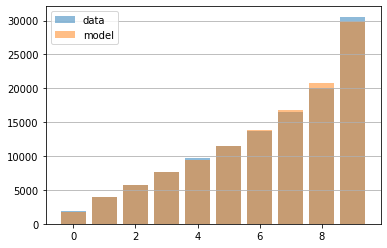

In [7]:
plt.bar(range(10), avg_income['2020'], alpha=0.5)
plt.bar(range(10), 
        weibull_decile_averages(optimizer.max['params']['c'], scale=optimizer.max['params']['scale']),
        alpha=0.5)
plt.legend(['data', 'model'])
plt.grid(axis='y')
plt.show()

# Income at 95% percentile

In [8]:
weibull_min.ppf(.95, optimizer.max['params']['c'], scale=optimizer.max['params']['scale'])

28102.876944726282